In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import math
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

Epoch 1/10: 100%|██████████| 15/15 [00:51<00:00,  3.41s/it]


Epoch [1/10] Loss: 0.7806


Epoch 2/10: 100%|██████████| 15/15 [00:43<00:00,  2.87s/it]


Epoch [2/10] Loss: 0.4357


Epoch 3/10: 100%|██████████| 15/15 [00:47<00:00,  3.19s/it]


Epoch [3/10] Loss: 0.2474


Epoch 4/10: 100%|██████████| 15/15 [00:46<00:00,  3.10s/it]


Epoch [4/10] Loss: 0.2112


Epoch 5/10: 100%|██████████| 15/15 [00:45<00:00,  3.01s/it]


Epoch [5/10] Loss: 0.1974


Epoch 6/10: 100%|██████████| 15/15 [00:45<00:00,  3.06s/it]


Epoch [6/10] Loss: 0.1840


Epoch 7/10: 100%|██████████| 15/15 [00:47<00:00,  3.16s/it]


Epoch [7/10] Loss: 0.1761


Epoch 8/10: 100%|██████████| 15/15 [00:44<00:00,  2.96s/it]


Epoch [8/10] Loss: 0.1683


Epoch 9/10: 100%|██████████| 15/15 [00:44<00:00,  2.94s/it]


Epoch [9/10] Loss: 0.1583


Epoch 10/10: 100%|██████████| 15/15 [00:44<00:00,  3.00s/it]


Epoch [10/10] Loss: 0.1511


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.241058..8.851413].


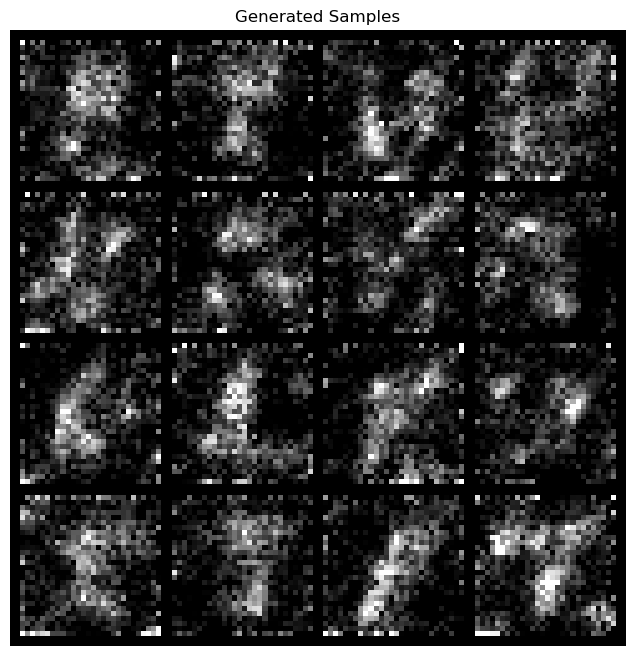

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import tqdm

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# -------------------------------
# Diffusion hyperparameters
# -------------------------------
T = 1000  # number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)  # cumulative product

# -------------------------------
# Sinusoidal Positional Embedding for time step t
# -------------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

# -------------------------------
# A simple U-Net–like model for noise prediction
# -------------------------------
class SimpleUnet(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, time_emb_dim=128):
        super(SimpleUnet, self).__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.conv1 = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(base_channels, base_channels * 2, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(base_channels * 2, base_channels * 4, 3, stride=2, padding=1)

        self.conv4 = nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1)

        self.deconv1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 4, stride=2, padding=1)
        self.conv_out = nn.Conv2d(base_channels, in_channels, 3, padding=1)

        self.time_dense1 = nn.Linear(time_emb_dim, base_channels * 4)

    def forward(self, x, t):
        t_emb = self.time_emb(t)

        h1 = F.relu(self.conv1(x))      
        h2 = F.relu(self.conv2(h1))       
        h3 = F.relu(self.conv3(h2))       

        h3_out = F.relu(self.conv4(h3))   

        t_feat = self.time_dense1(t_emb).unsqueeze(-1).unsqueeze(-1)
        h3_out = h3_out + t_feat

        h4 = F.relu(self.deconv1(h3_out))  
        h4 = h4 + h2  
        h5 = F.relu(self.deconv2(h4))      
        h5 = h5 + h1  

        out = self.conv_out(h5)  
        return out

# -------------------------------
# Dataset and DataLoader (MNIST)
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)  
])

train_dataset = torchvision.datasets.MNIST(root='datasets', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True, num_workers=0)

# -------------------------------
# KL Divergence Loss
# -------------------------------
def kl_divergence(pred_mean, pred_var, true_mean, true_var):
    """KL divergence between two Gaussian distributions."""
    kl = 0.5 * (torch.log(true_var) - torch.log(pred_var) +
                (pred_var + (pred_mean - true_mean) ** 2) / true_var - 1)
    return kl.mean()

# -------------------------------
# Initialize Model and Optimizer
# -------------------------------
model = SimpleUnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# -------------------------------
# Training Loop with KL Divergence
# -------------------------------
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        current_batch = images.size(0)
        
        t = torch.randint(0, T, (current_batch,), device=device).float()
        alpha_bar_t = alpha_bars[t.long()].view(-1, 1, 1, 1)

        noise = torch.randn_like(images)
        noisy_images = torch.sqrt(alpha_bar_t) * images + torch.sqrt(1 - alpha_bar_t) * noise
        
        noise_pred = model(noisy_images, t)
        
        # Original MSE Loss
        mse_loss = F.mse_loss(noise_pred, noise)

        # KL Divergence Loss
        pred_mean = noise_pred
        pred_var = torch.ones_like(pred_mean)  # Assuming isotropic Gaussian
        true_mean = noise
        true_var = torch.ones_like(true_mean)

        kl_loss = kl_divergence(pred_mean, pred_var, true_mean, true_var)

        # Combined Loss
        loss = mse_loss + 0.01 * kl_loss  # Weight the KL divergence term

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

# -------------------------------
# Sampling: Generate New Images
# -------------------------------
@torch.no_grad()
def sample(model, num_samples):
    model.eval()
    img_size = 28  # MNIST is 28x28
    x = torch.randn(num_samples, 1, img_size, img_size, device=device)
    for t in reversed(range(T)):
        t_tensor = torch.full((num_samples,), t, device=device).float()
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        
        noise_pred = model(x, t_tensor)
        
        coef = 1 / torch.sqrt(alpha_t)
        mean = coef * (x - ((beta_t / torch.sqrt(1 - alpha_bar_t)) * noise_pred))
        
        noise = torch.randn_like(x) if t > 0 else 0
        sigma_t = torch.sqrt(beta_t)
        x = mean + sigma_t * noise
    return x

# Generate a batch of samples
num_samples = 16
samples = sample(model, num_samples)
samples = (samples + 1) / 2

# Visualize the samples
grid = vutils.make_grid(samples, nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Generated Samples")
plt.show()


In [2]:
dataset_path = 'datasets'

device = torch.device("mps")

dataset = 'MNIST'
img_size = (32, 32, 3)   if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

train_batch_size = 128
inference_batch_size = 64
lr = 5e-5
epochs = 200

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
transforms = transforms.Compose([
    transforms.ToTensor(),
])
if dataset == 'CIFAR10':
    train_dataset = CIFAR10(root = dataset_path, train=True, download=True, transform=transforms)
    test_dataset = CIFAR10(root= dataset_path, train=False, download=True, transform=transforms)
else:
    train_dataset = MNIST(root = dataset_path, train=True, download=True, transform=transforms)
    test_dataset = MNIST(root= dataset_path, train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=inference_batch_size, shuffle=False)

In [4]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [5]:
# class ConvBlock(nn.Conv2d):
#     def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
#                     stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        
#         if padding == 'same':
#             padding = kernel_size // 2 * dilation
            
#         super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
#                                             stride=stride, padding=padding, dilation=dilation,
#                                             groups=groups, bias=bias)

#         self.activation_fn = nn.SiLU() if activation_fn else None
#         self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
#     def forward(self, x, time_embedding=None, residual=False):
        
#         if residual:
#             x = x + time_embedding
#             y = x
#             x = super(ConvBlock, self).forward(x)
#             y = y + x
#         else:
#             y = super(ConvBlock, self).forward(x)
#         y = self.group_norm(y) if self.group_norm is not None else y
#         y = self.activation_fn(y) if self.activation_fn is not None else y
        
#         return y

In [6]:
import torch
import torch.nn as nn

class UNetConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, activation=True,
                 dropout=0.0, padding='same', dilation=1, gn=True, gn_groups=4,
                 time_embedding_dim=None, residual=True):
        super().__init__()
        
        # Calculate padding if 'same'
        if padding == 'same':
            padding_val = (kernel_size // 2) * dilation
        else:
            padding_val = padding
        
        self.residual = residual
        
        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size,
                               stride=1, padding=padding_val, dilation=dilation, bias=True)
        self.norm1 = nn.GroupNorm(gn_groups, out_channels) if gn else nn.Identity()
        self.act1 = nn.SiLU() if activation else nn.Identity()
        
        # Optional time embedding projection
        if time_embedding_dim is not None:
            self.time_proj = nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_embedding_dim, out_channels)
            )
        else:
            self.time_proj = None
        
        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size,
                               stride=1, padding=padding_val, dilation=dilation, bias=True)
        self.norm2 = nn.GroupNorm(gn_groups, out_channels) if gn else nn.Identity()
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()
        self.act2 = nn.SiLU() if activation else nn.Identity()
        
        # Define shortcut: if input and output channels differ, use a 1x1 conv to match dimensions
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, time_embedding=None):
        # Shortcut connection for residual addition
        shortcut = self.shortcut(x)
        
        # First convolution block
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.act1(out)
        
        # Inject time embedding if provided
        if self.time_proj is not None and time_embedding is not None:
            # time_embedding shape: (batch, time_embedding_dim) -> reshape to (batch, out_channels, 1, 1)
            time_emb = self.time_proj(time_embedding).unsqueeze(-1).unsqueeze(-1)
            out = out + time_emb
        
        # Second convolution block
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.dropout(out)
        out = self.act2(out)
        
        # Return residual addition if enabled
        if self.residual:
            return out + shortcut
        else:
            return out

In [7]:
import torch
import torch.nn as nn

class Denoiser(nn.Module):
    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim=256, n_times=1000):
        super().__init__()
        
        _, _, img_C = image_resolution
        
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        self.in_project = UNetConvBlock(img_C, hidden_dims[0], kernel_size=7)
        
        self.time_project = nn.Sequential(
            UNetConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1),
            UNetConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1)
        )
        
        self.convs = nn.ModuleList()
        self.convs.append(UNetConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=3))
        for i in range(1, len(hidden_dims)):
            dilation = 3 ** ((i - 1) // 2)
            self.convs.append(
                UNetConvBlock(hidden_dims[i], hidden_dims[i],
                          kernel_size=3,
                          dilation=dilation,
                          gn=True,
                          gn_groups=8)
            )
        
        self.out_project = UNetConvBlock(hidden_dims[1], out_channels=img_C, kernel_size=3)
    
    def forward(self, perturbed_x, diffusion_timestep):
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))
        
        y = self.in_project(perturbed_x)
        for conv in self.convs:
            y = conv(y, diffusion_embedding, residual=True)
        y = self.out_project(y)
        return y

model = Denoiser(
    image_resolution=img_size,
    hidden_dims=hidden_dims,
    diffusion_time_embedding_dim=timestep_embedding_dim,
    n_times=n_timesteps
).to(device)


ValueError: num_channels must be divisible by num_groups

In [ ]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
    
        super(Diffusion, self).__init__()
    
        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model
        
        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device) # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)
                                     
        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)
        
        self.device = device
    
    def extract(self, a, t, x_shape):
        """
            from lucidrains' implementation
                https://github.com/lucidrains/denoising-diffusion-pytorch/blob/beb2f2d8dd9b4f2bd5be4719f37082fe061ee450/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L376
        """
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))
    
    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1
    
    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5
    
    def make_noisy(self, x_zeros, t): 
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)
        
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        
        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar
    
        return noisy_sample.detach(), epsilon
    
    
    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        
        B, _, _, _ = x_zeros.shape
        
        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)
        
        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)
        
        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)
        
        return perturbed_images, epsilon, pred_epsilon
    
    
    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)
        
        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)
        
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)
        
        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z
        
        return x_t_minus_1.clamp(-1., 1)
                
    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)
        
        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)
        
        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)
        
        return x_0
    
    
diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps, 
                      beta_minmax=beta_minmax, device=device).to(device)

optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(diffusion))

Number of model parameters:  4870913


In [ ]:
model.eval()
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(device)
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

In [ ]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())


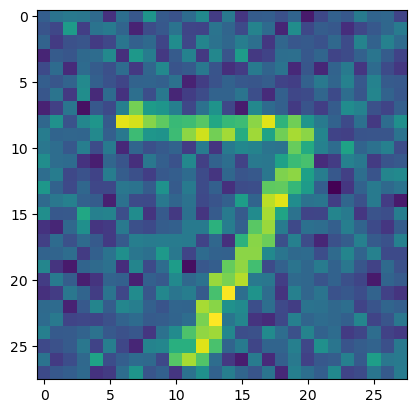

In [ ]:
import matplotlib.pyplot as plt
show_image(perturbed_images, idx=0)


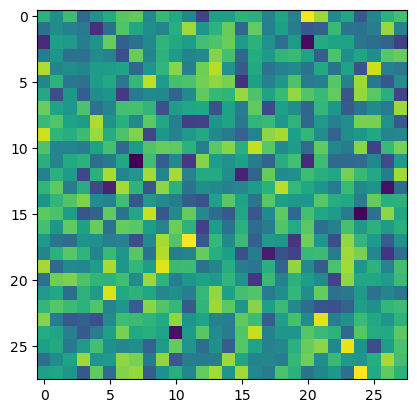

In [ ]:
show_image(perturbed_images, idx=1)
